In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import collections
from functools import partial
import seaborn as sn
import pandas as pd

### Entropy
 - Compute the entropy of a vector $Y$ by considering the counts of the unique values $(y_1, ... y_k)$, in $Y$
 - Returns the entropy of $Y: H(Y) = - P_Y(y_1)log_2(P_Y(y_1)) - ... - P_Y(y_k)log_2(P_Y(y_k))$

In [ ]:
def entropy(y, pro=None):
    if not isinstance(pro, np.ndarray):
        total = len(y)
        pro = np.array([1/total for _ in range(total)])
    uniques = partition(y)
    ent = 0

    for _, idx in uniques.items():
        p = np.sum(pro[idx])
        ent -= p*np.log2(p)
    return ent

In [ ]:
def gen_attr_val_pair(x):
    attr_val = []
    for attribute in range(len(x[0])):
        for val in np.unique(x[:, attribute]):
            attr_val.append((attribute, val))
    return attr_val

### partition

In [ ]:
def partition(x):
    x_unique = np.unique(x)
    par = {i: np.where(x == i)[0] for i in x_unique}
    return par

### Mutual Information

In [ ]:
def mutual_information(x, y, pro=None):
    if not isinstance(pro, np.ndarray):
        total = len(y)
        pro = np.array([1/total for _ in range(total)])
    H_y = entropy(y, pro)
    uniques = partition(x)

    H_yx = 0
    for val, idn in uniques.items():
        p = np.sum(pro[idn])
        H_yx += p * entropy(y[idn], pro[idn])
    
    return H_y - H_yx
    

    

### Visualization of Tree

In [ ]:
def visualize(tree, depth=0):
    """
    Pretty prints (kinda ugly, but hey, it's better than nothing) the decision tree to the console. Use print(tree) to
    print the raw nested dictionary representation.
    DO NOT MODIFY THIS FUNCTION!
    """

    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        # Print the current node: split criterion
        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1}]'.format(split_criterion[0], split_criterion[1]))

        # Print the children
        if type(sub_trees) is dict:
            visualize(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))

In [ ]:
def pretty_print(tree, depth=0):
    """
    Pretty prints the decision tree to the console. Use print(tree) to print the raw nested dictionary representation
    DO NOT MODIFY THIS FUNCTION!
    """
    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        # Print the current node: split criterion
        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1} {2}]'.format(split_criterion[0], split_criterion[1], split_criterion[2]))

        # Print the children
        if type(sub_trees) is dict:
            pretty_print(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))

### ID3 Algorithm

 - Implements the classical ID3 algorithm given training data (x), training labels (y) and an array of
    attribute-value pairs to consider. 
 - This is a recursive algorithm that depends on three termination conditions:
       1. If the entire set of labels (y) is pure (all y = only 0 or only 1), then return that label
       2. If the set of attribute-value pairs is empty (there is nothing to split on), then return the most common
           value of y (majority label)
       3. If the max_depth is reached (pre-pruning bias), then return the most common value of y (majority label)
    Otherwise the algorithm selects the next best attribute-value pair using INFORMATION GAIN as the splitting criterion
    and partitions the data set based on the values of that attribute before the next recursive call to ID3.

 - The tree we learn is a BINARY tree, which means that every node has only two branches. The splitting criterion has to be chosen from among all possible attribute-value pairs. That is, for a problem with two features/attributes x1 (taking values a, b, c) and x2 (taking values d, e), the initial attribute value pair list is a list of all pairs of
    attributes with their corresponding values:
    
    \[ ($x_1$, a),
      ($x_1$, b,)
      ($x_1$, c),
      ($x_2$, d),
      ($x_2$, e) \]
     
     If we select (x2, d) as the best attribute-value pair, then the new decision node becomes: [ (x2 == d)? ] and
     the attribute-value pair (x2, d) is removed from the list of attribute_value_pairs.

 - The tree is stored as a nested dictionary, where each entry is of the form
                    (attribute_index, attribute_value, True/False): subtree
    * The (attribute_index, attribute_value) determines the splitting criterion of the current node. For example, (4, 2) indicates that we test if (x4 == 2) at the current node.
    * The subtree itself can be nested dictionary, or a single label (leaf node).
    * Leaf nodes are (majority) class labels

 - Returns a decision tree represented as a nested dictionary, for example
        {(4, 1, False):
            {(0, 1, False):
                {(1, 1, False): 1,
                 (1, 1, True): 0},
             (0, 1, True):
                {(1, 1, False): 0,
                 (1, 1, True): 1}},
         (4, 1, True): 1}

In [ ]:
def id3(x, y, attribute_val_pair=None, depth=0, max_depth=3, dist=None):
    if not isinstance(dist, np.ndarray):
        total = len(y)
        dist = np.array([1/total for _ in range(total)])
    # get unique counts and values from labels
    uniquey, ycount = np.unique(y, return_counts=True)
    
    # no examples got splitted to this node, prune this node
    if len(ycount) == 0:
        return None
    
    # all examples are from only one class, so return the class label
    if len(uniquey) == 1:
        return uniquey[0]

    # no more attribute value pairs remaning or we have reached max required depth
    if len(attribute_val_pair) == 0 or depth == max_depth:
        return uniquey[np.argmax(ycount)]
    
    # compute information for all possible attribute value pairs
    information_gain = []
    for attribute, value in attribute_val_pair:
        information_gain.append(mutual_information(x[:, attribute] == value, y))
    
    best_split_idx = np.argmax(information_gain)
    
    attr, val = attribute_val_pair[best_split_idx]
    attribute_val_pair = np.delete(attribute_val_pair, best_split_idx, axis=0)
    
    left_idx = np.where(x[:, attr] == val)[0]
    right_idx = np.where(x[:, attr] != val)[0]
    
    x_left = x[left_idx]
    y_left = y[left_idx]
    dist_left = dist[left_idx]
    x_right = x[right_idx]
    y_right = y[right_idx]
    dist_right = dist[right_idx]
    
    right_sub_tree = id3(x_right, y_right, attribute_val_pair, depth + 1, max_depth, dist_right)
    left_sub_tree = id3(x_left, y_left, attribute_val_pair, depth + 1, max_depth, dist_left)
    if right_sub_tree is not None and left_sub_tree is not None:
        
        node = {(attr, val, False): right_sub_tree,
                (attr, val, True): left_sub_tree}
        return node
    
    return uniquey[np.argmax(ycount)]


### predict example

In [ ]:
def predict(x, tree):
        if type(tree) is not dict:
            return tree
        for attribute, value, test in tree:
            if (x[attribute] == value) == test:
                return predict(x, tree[(attribute, value, test)])

### compute error

In [ ]:
def compute_error(ytrue, ypred, dist=None):
    if not isinstance(dist, np.ndarray):
        total = len(ytrue)
        dist = np.array([1/total for _ in range(total)])
    return sum((yt != yp)*d for yt, yp, d in zip(ytrue, ypred, dist))

### Confusion Table

In [ ]:
def confusion_table(y_true, y_pred):
    tp = tn = fp = fn = 0
    
    for yp, yt in zip(y_pred, y_true):
        
        if yp == 1:
            if yt == 1:
                tp += 1
            else:
                fp += 1
        else:
            if yt == 0:
                tn += 1
            else:
                fn += 1
    
    return [[tp, fn], [fp, tn]]

### train and get errors

In [ ]:
def train(Xtrain, Ytrain, Xtest, Ytest, initial_depth=1, final_depth=10, return_trees=False, return_confusion=False):
    attr_val_pair = []
    for attribute in range(len(Xtrain[0])):
        for val in np.unique(Xtrain[:, attribute]):
            attr_val_pair.append((attribute, val))
    
    train_err = []
    test_err = []
    trees = []
    confusion_tables=[]
    
    for depth in range(initial_depth, final_depth+1):
        decision_tree = id3(Xtrain, Ytrain, attr_val_pair, max_depth=depth)
        trees.append(decision_tree)
        
        y_pred_train = [predict_example(x, decision_tree) for x in Xtrain]
        y_pred_test = [predict_example(x, decision_tree) for x in Xtest]
        
        confusion_tables.append(confusion_table(Ytest, y_pred_test))
        
        train_err.append(compute_error(Ytrain, y_pred_train))
        test_err.append(compute_error(Ytest, y_pred_test))
    
    if return_trees and return_confusion:
        return train_err, test_err, trees, confusion_tables
    if return_trees:
        return train_err, test_err, trees
    if return_confusion:
        return train_err, test_err, confusion_tables
    return train_err, test_err


### plot errors

In [ ]:
def plot_errors(train_err, test_err, plot_title=None, save=False):
    
    plt.plot(list(range(1, len(train_err)+1)), train_err, label="train-error")
    plt.plot(list(range(1, len(test_err)+1)), test_err, label="test-error")
    plt.title(plot_title)
    plt.legend()
    plt.savefig(plot_title.replace(' ','_') + '.png')
    plt.show()


### Creating Confusion Matrix

In [ ]:
def confusion_tree(ytest, y_pred_test):
    cm = confusion_matrix(ytest, y_pred_test)
    print(cm)
    labels=['positive','negative']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Classifier Prediction')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual Value')
    plt.show()

### 

## main

### load data

In [ ]:
def load_data(M,N):
    ytrain = M[:, 0]
    Xtrain = M[:, 1:] 
    
    ytest = N[:, 0]
    Xtest = N[:, 1:]
    
    return Xtrain,ytrain,Xtest,ytest
    


In [ ]:
def my_decision_tree(M,N,depth):
    Xtrain,ytrain,Xtest,ytest=load_data(M,N)
    y_pred_test,train_err, test_err,decision_tree = main(Xtrain, ytrain, Xtest, ytest, depth)
    #plot_errors(trn_err, tst_err, "Dataset error plots", True)
    
    return y_pred_test, ytest,decision_tree
   
    

### Scikit-Learn

In [ ]:
def scikit_learn(M,N):
    Xtrain,ytrain,Xtest,ytest=load_data(M,N)
    model = tree.DecisionTreeClassifier() # for classification, here default is gini
    model.fit(Xtrain, ytrain)
    
 
    predicted = model.predict(Xtest)
    print("accuracy: "+str(model.score(Xtest,ytest)))
    print("confusion matrix is below:-")
    confusion_tree(ytest,predicted)


### Question 1

### Mushroom Dataset

### Main bagging and boosting

In [138]:
def bootstrap_samples(size, T=200):

    while T > 0:
        yield np.random.choice(size, size, replace=True)
        T-=1

### Load Data

In [145]:
M = np.genfromtxt('mushroom/mushroom.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
N = np.genfromtxt('mushroom/mushroom.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)

Xtrn,ytrn,Xtst,ytst=load_data(M,N)

### Bagging

In [140]:
def bagging(x, y, max_depth, num_trees):
    sample_idx = bootstrap_samples(x.shape[0], num_trees)
    # TODO: Do we define attribute value pair for each bootstrap sample? :yes
    # TODO: What to return?
    h_ens = []
    for idx in sample_idx:
        Xtrain = x[idx]
        Ytrain = y[idx]
        
        attr_val_pair = gen_attr_val_pair(Xtrain)
        decision_tree = id3(Xtrain, Ytrain, attr_val_pair, max_depth=max_depth)
        h_ens.append((1/num_trees, partial(predict, tree=decision_tree)))
        
    return h_ens

### Boosting

In [141]:
def boosting(Xtrain, Ytrain, max_depth, num_stumps):
    # TODO: compute error for xtrain?
    # TODO: how to determine alpha?
    total = len(Ytrain)
    D = np.array([1/total for _ in range(total)])
    
    h_ens = []
    attr_val_pair = gen_attr_val_pair(Xtrain)
    
    for i in range(num_stumps):
        # Learn
        decision_tree = id3(Xtrain, Ytrain, attr_val_pair, max_depth=max_depth, dist=D)
        
        # Error
        h = partial(predict, tree=decision_tree)
        y_pred = [h(x) for x in Xtrain]
        error = compute_error(Ytrain, y_pred, D)
        
        # Update weights
        alpha = -0.5*np.log2(error) # ln((1-e)/e) = ln(1/e - 1) = ln(1/e) = -ln(e)
        for i in range(len(D)):
            D[i] = D[i]*np.exp(alpha if y_pred[i] != Ytrain[i] else -alpha)
        
        h_ens.append((alpha, h))
        
        D = D / np.sum(D)
        #print(alpha, error, np.sum(D))
        
    return h_ens

### Predict

In [142]:
def predict_example(x, h_ens):
    """
    h_ens = list of (h_i, alpha_i)
    """
    pred = 0
    for alpha, h in h_ens:
        pred+=alpha*h(x)
    return int(pred>=0.5)

### Bagging

[[1167   20]
 [   0  844]]


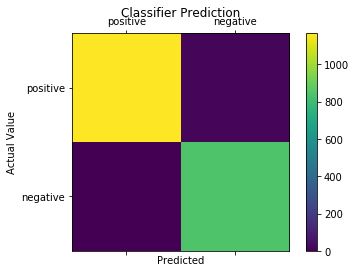

[[1167   20]
 [   0  844]]


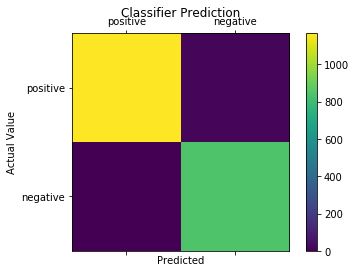

[[1135   52]
 [   4  840]]


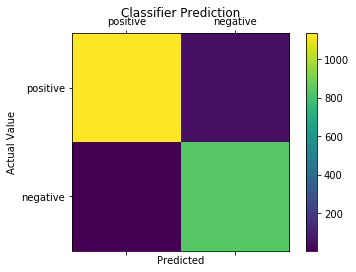

[[1135   52]
 [   4  840]]


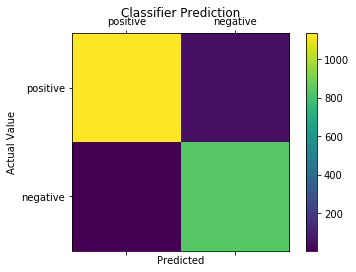

In [143]:
depth1=3
depth2=5

bag_size1=10
bag_size2=20


num_trees1 = 20
num_trees2 =10
max_depth1 = 5
max_depth2 = 3

Xtrn,Ytrn,Xtst,Ytst=load_data(M,N)
h_ens = bagging(Xtrn, Ytrn, max_depth1, num_trees1)
y_pred_tst = [predict_example(x, h_ens) for x in Xtst]
compute_error(Ytst, y_pred_tst)
confusion_tree(Ytst, y_pred_tst)

h_ens = bagging(Xtrn, Ytrn, max_depth1, num_trees2)
y_pred_tst = [predict_example(x, h_ens) for x in Xtst]
compute_error(Ytst, y_pred_tst)
confusion_tree(Ytst, y_pred_tst)

h_ens = bagging(Xtrn, Ytrn, max_depth2, num_trees1)
y_pred_tst = [predict_example(x, h_ens) for x in Xtst]
compute_error(Ytst, y_pred_tst)
confusion_tree(Ytst, y_pred_tst)

h_ens = bagging(Xtrn, Ytrn, max_depth2, num_trees2)
y_pred_tst = [predict_example(x, h_ens) for x in Xtst]
compute_error(Ytst, y_pred_tst)
confusion_tree(Ytst, y_pred_tst)


### Boosting

[[1078  109]
 [  28  816]]


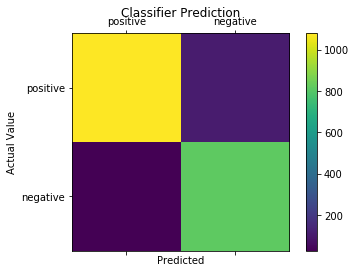

[[1078  109]
 [  28  816]]


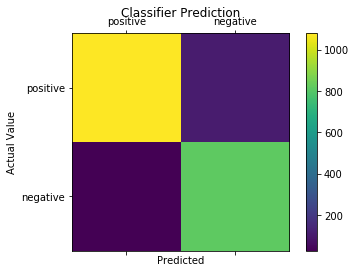

[[981 206]
 [ 51 793]]


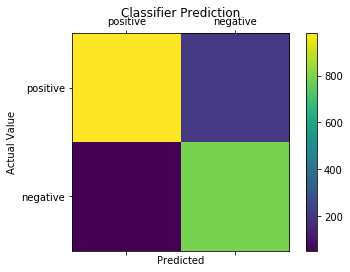

[[981 206]
 [ 51 793]]


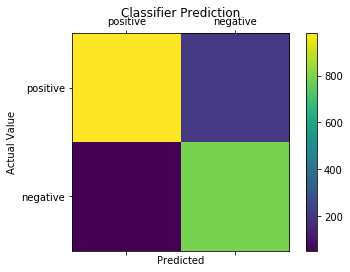

In [144]:
max_depth1 = 2
max_depth2 = 1
num_stumps1 = 20
num_stumps2 = 40


h_ens = boosting(Xtrn, Ytrn, max_depth1, num_stumps1)
y_pred_tst = [predict_example(x, h_ens) for x in Xtst]
compute_error(Ytst, y_pred_tst)
confusion_tree(Ytst, y_pred_tst)

h_ens = boosting(Xtrn, Ytrn, max_depth1, num_stumps2)
y_pred_tst = [predict_example(x, h_ens) for x in Xtst]
compute_error(Ytst, y_pred_tst)
confusion_tree(Ytst, y_pred_tst)

h_ens = boosting(Xtrn, Ytrn, max_depth2, num_stumps1)
y_pred_tst = [predict_example(x, h_ens) for x in Xtst]
compute_error(Ytst, y_pred_tst)
confusion_tree(Ytst, y_pred_tst)

h_ens = boosting(Xtrn, Ytrn, max_depth2, num_stumps2)
y_pred_tst = [predict_example(x, h_ens) for x in Xtst]
compute_error(Ytst, y_pred_tst)
confusion_tree(Ytst, y_pred_tst)


### Bagging with Scikit-Learn

confusion matrix is below:-
[[1185    2]
 [ 117  727]]


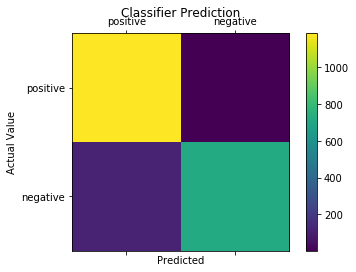

confusion matrix is below:-
[[1185    2]
 [ 117  727]]


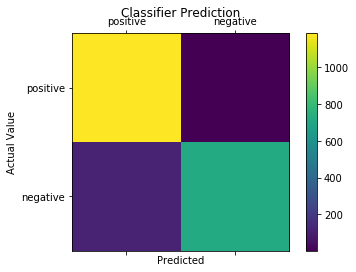

confusion matrix is below:-
[[1182    5]
 [   9  835]]


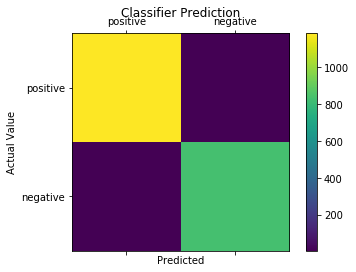

confusion matrix is below:-
[[1179    8]
 [   9  835]]


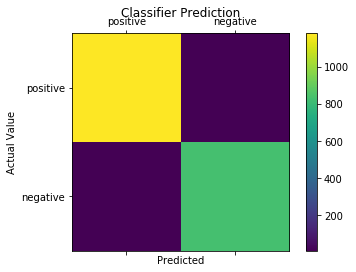

In [131]:
M = np.genfromtxt('mushroom/mushroom.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
N = np.genfromtxt('mushroom/mushroom.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)

Xtrain,ytrain,Xtest,ytest = load_data(M,N)

t_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
abc = BaggingClassifier(base_estimator=t_tree,n_estimators=10)
model = abc.fit(Xtrain,ytrain)
predicted = model.predict(Xtest)
print("confusion matrix is below:-")
confusion_tree(ytest,predicted)

#Question 3 bagging part2


t_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3) 
abc = BaggingClassifier(base_estimator=t_tree,n_estimators=20)
model = abc.fit(Xtrain,ytrain)
predicted = model.predict(Xtest)
print("confusion matrix is below:-")
confusion_tree(ytest,predicted)

#Question 3 bagging part3


t_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
abc = BaggingClassifier(base_estimator=t_tree,n_estimators=10)
model = abc.fit(Xtrain,ytrain)
predicted = model.predict(Xtest)
print("confusion matrix is below:-")
confusion_tree(ytest,predicted)

#Question 3 bagging part4


t_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=5)
abc = BaggingClassifier(base_estimator=t_tree,n_estimators=20)
model = abc.fit(Xtrain,ytrain)
predicted = model.predict(Xtest)
print("confusion matrix is below:-")
confusion_tree(ytest,predicted)

### Boosting with Scikit-Learn

confusion matrix is below:-
[[1185    2]
 [   0  844]]


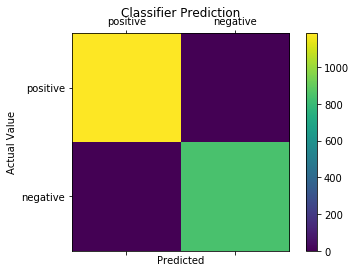

confusion matrix is below:-
[[1187    0]
 [   0  844]]


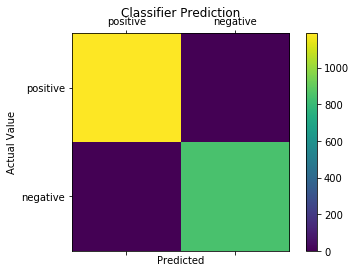

confusion matrix is below:-
[[1187    0]
 [   0  844]]


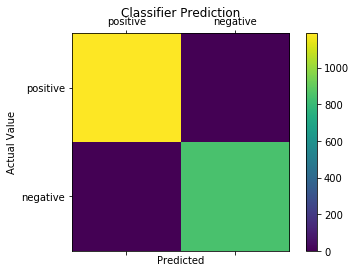

confusion matrix is below:-
[[1187    0]
 [   0  844]]


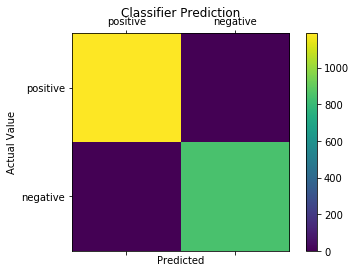

In [134]:
#Question 3 boosting part1
from sklearn.ensemble import AdaBoostClassifier
M = np.genfromtxt('mushroom/mushroom.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
N = np.genfromtxt('mushroom/mushroom.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)

Xtrain,ytrain,Xtest,ytest = load_data(M,N)

t_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=1)
abc =AdaBoostClassifier(n_estimators=20, base_estimator=t_tree,learning_rate=1)
model = abc.fit(Xtrain,ytrain)
predicted = model.predict(Xtest)
print("confusion matrix is below:-")
confusion_tree(ytest,predicted)

#Question 3 boosting part2


t_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=1) 
abc =AdaBoostClassifier(n_estimators=40, base_estimator=t_tree,learning_rate=1)
model = abc.fit(Xtrain,ytrain)
predicted = model.predict(Xtest)
print("confusion matrix is below:-")
confusion_tree(ytest,predicted)

#Question 3 boosting part3


t_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=2)
abc =AdaBoostClassifier(n_estimators=20, base_estimator=t_tree,learning_rate=1)
model = abc.fit(Xtrain,ytrain)
predicted = model.predict(Xtest)
print("confusion matrix is below:-")
confusion_tree(ytest,predicted)

#Question 3 boosting part4

t_tree = tree.DecisionTreeClassifier(criterion='entropy',max_depth=2)
abc =AdaBoostClassifier(n_estimators=40, base_estimator=t_tree,learning_rate=1)
model = abc.fit(Xtrain,ytrain)
predicted = model.predict(Xtest)
print("confusion matrix is below:-")
confusion_tree(ytest,predicted)

